In [80]:
from cleaning import get_clean_data,get_data
import numpy as np
import matplotlib.pyplot as plt
data = get_clean_data()


Sevirity precentages:

Not injured        50.62%
Minor injury       19.32%
Injury Unknown     14.47%
Moderate injury    9.405%
Unknown            3.663%
Major injury       1.968%
Killed             0.537%
Name: MAX_SEVERITY_LEVEL, dtype: object


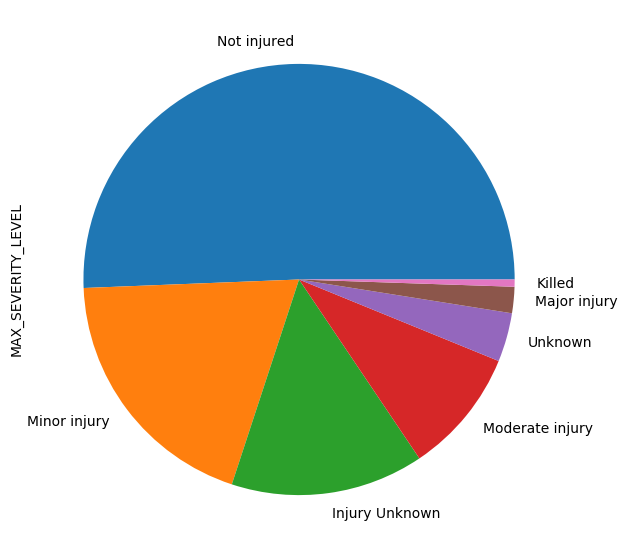

In [140]:
#first figuer pie char of injury level

labels={0:'Not injured',
1:'Killed',
2:'Major injury',
3:'Moderate injury',
4:'Minor injury',
8:'Injury Unknown',
9:'Unknown'}
severity_data=data['MAX_SEVERITY_LEVEL'].value_counts()
severity_data= severity_data.rename(labels)
severity_data.plot.pie(figsize=(7,7))
total = severity_data.sum()
sev = severity_data.apply(lambda x: str(x/total*100)[:5]+'%')
print('Sevirity precentages:\n')
print(sev)

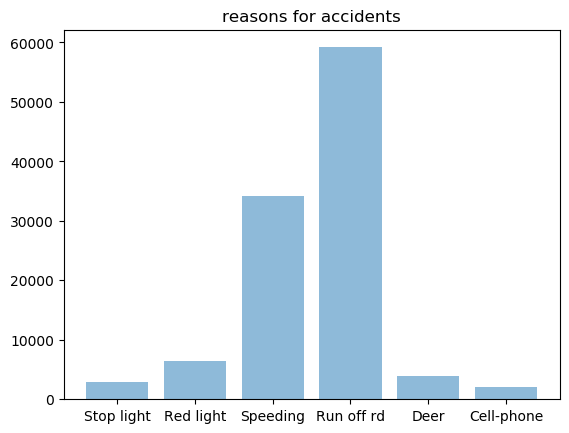

In [118]:
#second figure : reasons for accidents:
reasons=[
'RUNNING_STOP_SIGN',
'RUNNING_RED_LT',
'SPEEDING_RELATED',
'SV_RUN_OFF_RD',
'SUDDEN_DEER',
'CELL_PHONE',
]
labels = ['Stop light','Red light','Speeding','Run off rd','Deer','Cell-phone']
total =0
counts=[]
for i in reasons:
    total+=len(data[data[i]==1].index)
    counts.append(len(data[data[i]==1].index))
y_pos = np.arange(len(reasons))
plt.rcdefaults()
plt.bar(y_pos, counts, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.title('reasons for accidents')
plt.show()




In [141]:
#feature engineering
#creat new categorical column for time of day
import pandas as pd
data = get_data("crash.csv")
f = data['TIME_OF_DAY'].dropna()
f = data.loc[(data.TIME_OF_DAY > 0) & (data.TIME_OF_DAY < 2400)]
f=f[f['AGGRESSIVE_DRIVING']==1]

bins = [-np.inf,600,1200,1800,2400]

labels=['late night','morning','afternoon','night']

f['time'] = pd.cut(data.TIME_OF_DAY, bins=bins, labels=labels)

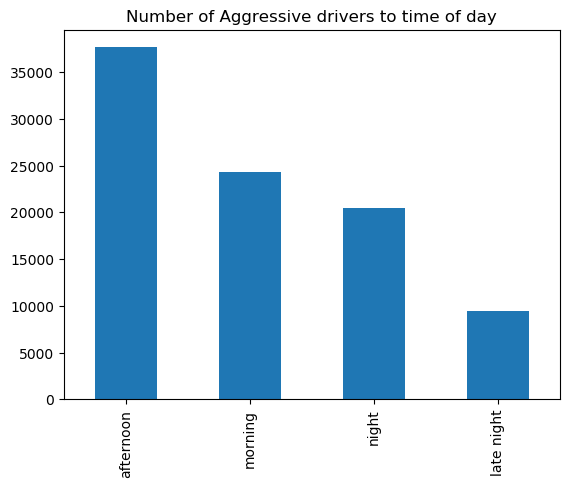

In [142]:
#figure 3 : aggresive drivers per time of day
#late night:12am-6am, morning :6am
plt.title('Number of Aggressive drivers to time of day')
f['time'].value_counts().plot(kind='bar')

